<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE577-5G-Architectures-Technologies-Applications-and-Key-Performance-Indicators/blob/main/Code/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install tensorflow


In [1]:
!pip install keras

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3789/3789 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 0.2202 - val_loss: 0.1477
Epoch 2/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.1619 - val_loss: 0.1395
Epoch 3/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.1556 - val_loss: 0.1374
Epoch 4/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.1508 - val_loss: 0.1388
Epoch 5/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.1483 - val_loss: 0.1336
Epoch 6/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.1471 - val_loss: 0.1359
Epoch 7/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.1460 - val_loss: 0.1327
Epoch 8/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.1436 - val_loss: 0.1322
Epoch 9/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.1408 - val_loss: 0.1321
Epoch 10/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.1421 - val_loss: 0.1329
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

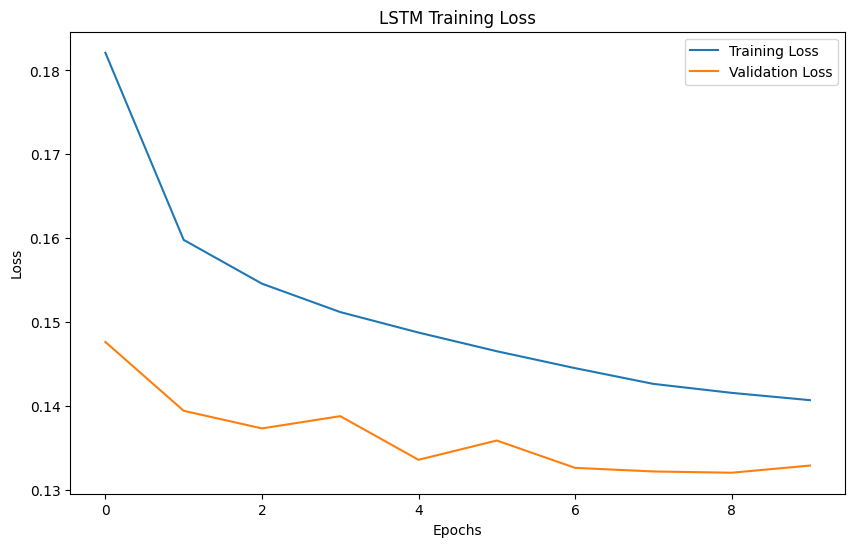

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Φόρτωση του τελικού dataset
df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv")

# Ορισμός των χαρακτηριστικών και του στόχου
features = df.columns.difference(["DL_bitrate"])

# Ορισμός διαστήματος καθυστέρησης και αριθμού lags
lag_interval = 100  # Δημιουργία lags ανά 100 δευτερόλεπτα
num_lags = 5  # Δημιουργούμε 5 διαφορετικά lags

def create_time_series_data(df, features, target, num_lags, lag_interval):
    df = df.copy()
    for feature in features:
        for lag in range(lag_interval, lag_interval * num_lags + 1, lag_interval):
            df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
    df = df.dropna()

    X, y = [], []
    for i in range(num_lags, len(df)):
        X.append(df.iloc[i - num_lags:i][features].values)
        y.append(df.iloc[i][target])
    return np.array(X), np.array(y)

# Δημιουργία time-series dataset
X, y = create_time_series_data(df, features, "DL_bitrate", num_lags, lag_interval)

# Διαχωρισμός σε Training, Validation και Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Κατασκευή του LSTM Μοντέλου
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(num_lags, X.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Εκπαίδευση του μοντέλου
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Πρόβλεψη στα σύνολα Train, Validation και Test
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Υπολογισμός των μετρικών σφάλματος
metrics = {
    "Set": ["Train", "Validation", "Test"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_val, y_val_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred)),
    ],
    "MAE": [
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_val, y_val_pred),
        mean_absolute_error(y_test, y_test_pred),
    ],
    "MAPE": [
        mean_absolute_percentage_error(y_train, y_train_pred),
        mean_absolute_percentage_error(y_val, y_val_pred),
        mean_absolute_percentage_error(y_test, y_test_pred),
    ],
}

metrics_df = pd.DataFrame(metrics)
print("LSTM Model Performance:")
print(metrics_df)

# Οπτικοποίηση της διαδικασίας εκπαίδευσης
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training Loss')
plt.legend()
plt.show()
